# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

## Keras Update

In [ ]:
!pip install keras-nightly

In [ ]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2024-10-23 06:58:09--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat.4’

notMNIST_small.mat. 100%[===================>] 112.14M  16.2MB/s    in 8.6s    

2024-10-23 06:58:18 (13.1 MB/s) - ‘notMNIST_small.mat.4’ saved [117586976/117586976]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import io

## Data Loading

In [ ]:
data = io.loadmat('notMNIST_small.mat')

In [ ]:
x = data['images']
y = data['labels']

In [ ]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [ ]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [ ]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

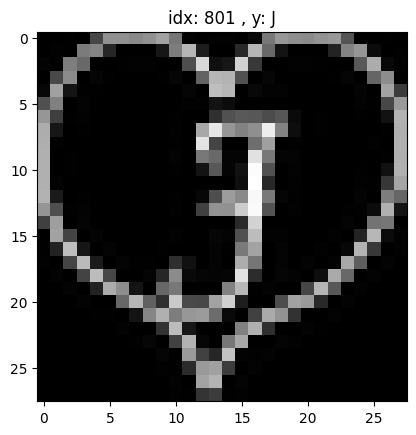

In [ ]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='gray' )
plt.show()

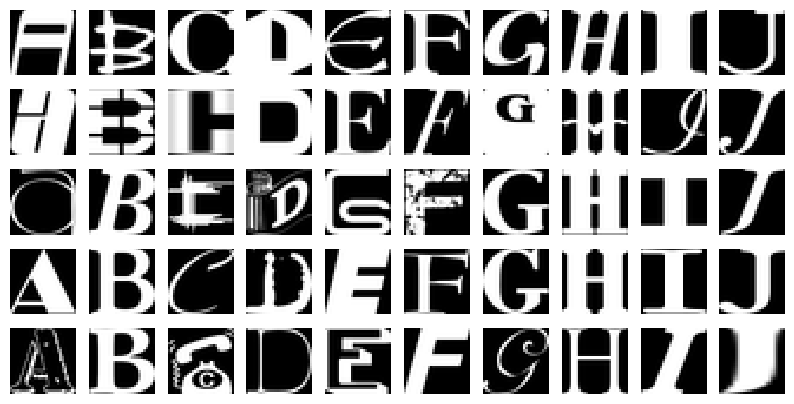

In [ ]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='gray', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split
    - training set : test set = 8 : 2
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2024)

* Scaling

    - min-max scaling

In [ ]:
# train_x = train_x / 255.0
# test_x = test_x / 255.0
# val_x = val_x / 255.0
min, max = train_x.min(), train_x.max()
train_x = (train_x - min) / (max - min)
test_x = (test_x - min) / (max - min)
val_x = (val_x - min) / (max - min)

* One-hot encoding

In [ ]:
from keras.utils import to_categorical

class_n = len(np.unique(train_y))
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)
val_y = to_categorical(val_y, class_n)

In [ ]:
class_n

10

* Data shape 재확인

In [ ]:
train_x.shape, val_x.shape, test_x.shape

((11983, 28, 28, 1), (2996, 28, 28, 1), (3745, 28, 28, 1))

## **Image Precessing&Augmentation Layers**

In [93]:
import keras

In [108]:
aug_layers = [keras.layers.RandomRotation(factor=(-0.3,0.3)),
              keras.layers.RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3)),
              keras.layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
              keras.layers.RandomFlip(mode='horizontal_and_vertical')
              ]

In [109]:
def image_augmentation(images):
    for layer in aug_layers:
        images = layer(images)
    return images

In [110]:
aug_imgs = image_augmentation(train_x[0])

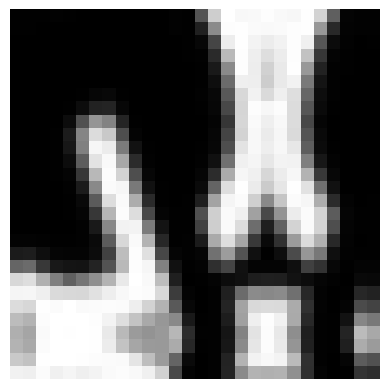

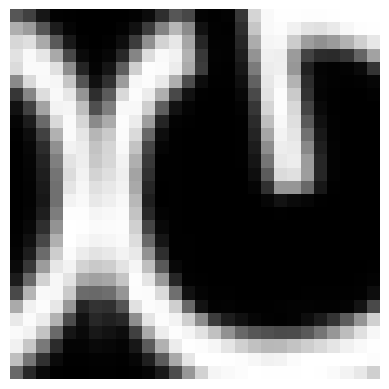

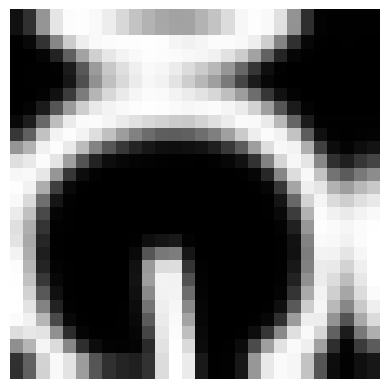

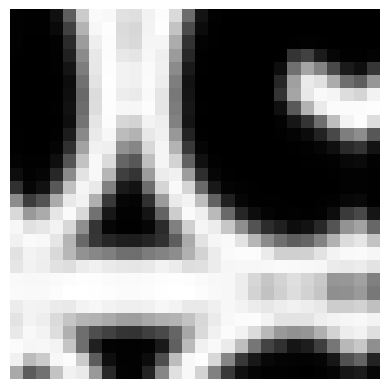

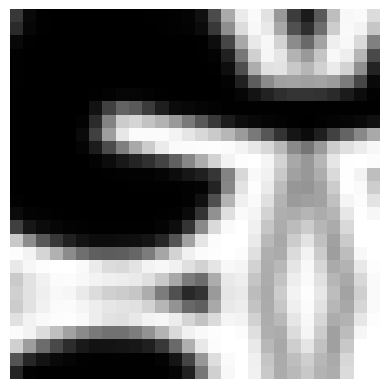

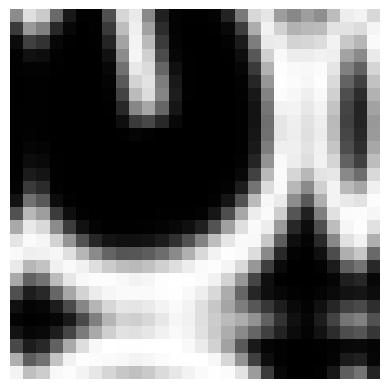

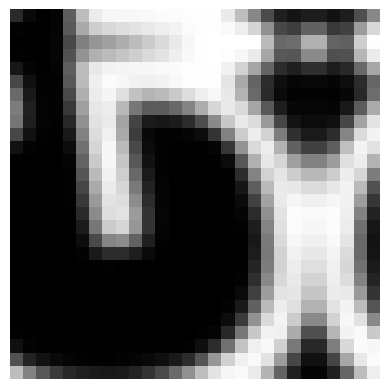

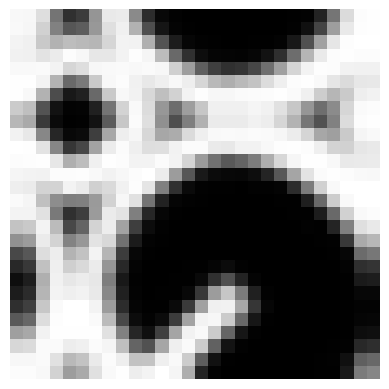

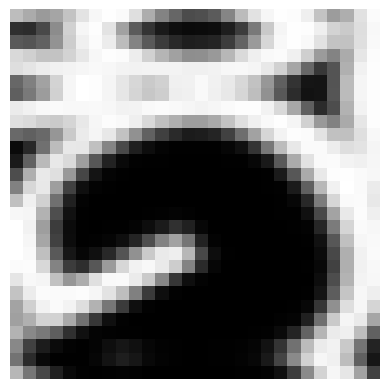

In [111]:
rand_n = np.random.randint(0, 11982)

for i in range(9) :
    aug_imgs = image_augmentation(train_x[rand_n])

    plt.imshow( np.array(aug_imgs), cmap='gray' )
    plt.axis('off')
    plt.show()

## 추가 - 만약 augmentation_image를 넣고 싶다면

In [ ]:
add_imgs = []
add_results = []

for i in range(len(train_x)):
    aug_imgs = image_augmentation(train_x[i])
    add_imgs.append(aug_imgs)
    add_results.append(train_y[i])

In [ ]:
add_imgs = np.array(add_imgs)
add_results = np.array(add_results)

In [ ]:
train_x = np.concatenate((train_x, add_imgs), axis=0)
train_y = np.concatenate((train_y, add_results), axis=0)

## Modeling : CNN + **Image Precessing&Augmentation**

- 조건
    1. Sequential API, Functional API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

In [ ]:
from keras.utils import clear_session, plot_model
from keras.models import Sequential, Model
from keras.layers import Flatten, Input, Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomFlip
from keras.callbacks import EarlyStopping

In [ ]:
# keras.layers.RandomRotation(factor=(-0.1,0.1)),
# keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
# keras.layers.RandomZoom(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
# keras.layers.RandomFlip(mode='horizontal_and_vertical')

In [ ]:
clear_session()

# 모델 선언 + 레이어 블록 조립 (이 안에 Augmentation Layer가 들어있어야 함!)
model = Sequential([Input(shape=(28,28,1)),
                    # =====================================================================
                    # keras에서 제공하는 Augmentation Layer는 Input 바로 아래에 있어야 함
                    RandomRotation(factor=(-0.3,0.3)),
                    RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3)),
                    RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
                    RandomFlip(mode='horizontal_and_vertical'),
                    # =====================================================================
                    Conv2D(64,3,1,'same',activation='relu'),
                    Conv2D(64,3,1,'same',activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(128,3,1,'same',activation='relu'),
                    Conv2D(128,3,1,'same',activation='relu'),
                    MaxPool2D(2,2),
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(10, activation='softmax')
                    ])


model. compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,692,810 (25.53 MB)

 Trainable params: 6,692,810 (25.53 MB)

 Non-trainable params: 0 (0.00 B)

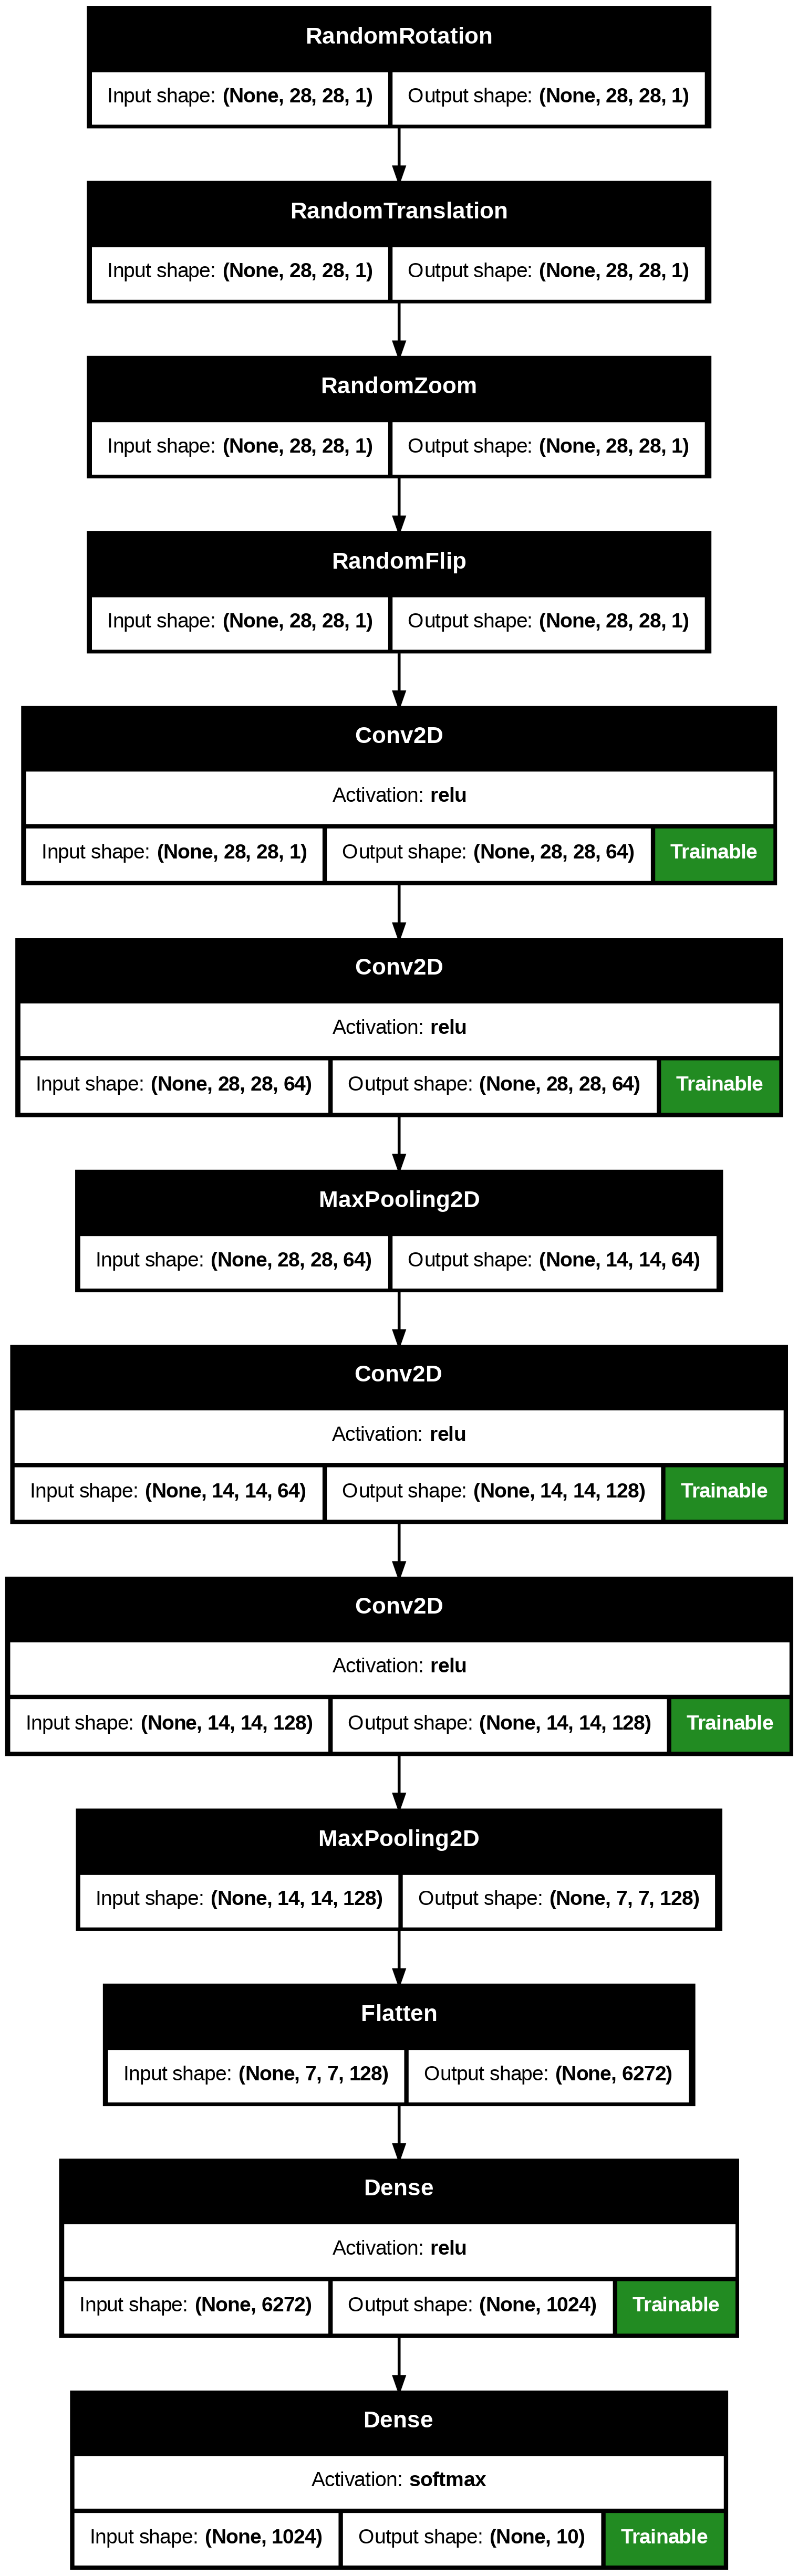

In [ ]:
plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)

* Early Stopping

In [ ]:
es = EarlyStopping(monitor = 'val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

* .fit( )

In [ ]:
history= model.fit(train_x, train_y, epochs=10000, validation_split=0.2, callbacks=[es])

Epoch 1/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1890 - loss: 2.1541 - val_accuracy: 0.3617 - val_loss: 1.7906
Epoch 2/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3484 - loss: 1.7954 - val_accuracy: 0.3721 - val_loss: 1.7020
Epoch 3/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4574 - loss: 1.5521 - val_accuracy: 0.5490 - val_loss: 1.3958
Epoch 4/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5470 - loss: 1.3380 - val_accuracy: 0.5949 - val_loss: 1.2787
Epoch 5/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5821 - loss: 1.2363 - val_accuracy: 0.6308 - val_loss: 1.1786
Epoch 6/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6302 - loss: 1.1125 - val_accuracy: 0.6358 - val_loss: 1.2363
Epoch 7/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6700 - loss: 1.0226 - val_accuracy: 0.6925 - val_loss: 1.0200
Epoch 8/10000
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6644 -

* .evaluate( )

In [ ]:
performance_test = model.evaluate(test_x, test_y)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.4976


* .predict( )

In [ ]:
y_pred = model.predict(test_x)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y, axis=1)

* 평가 지표

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_score(test_y_arg, y_pred_arg)

0.8453938584779707

In [ ]:
print( classification_report(test_y_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       360
           1       0.84      0.86      0.85       382
           2       0.90      0.79      0.84       385
           3       0.88      0.82      0.85       373
           4       0.78      0.80      0.79       364
           5       0.82      0.92      0.87       392
           6       0.78      0.90      0.84       390
           7       0.85      0.88      0.87       364
           8       0.92      0.82      0.87       360
           9       0.82      0.86      0.84       375

    accuracy                           0.85      3745
   macro avg       0.85      0.84      0.85      3745
weighted avg       0.85      0.85      0.85      3745



## Visualization

* 실제 데이터 확인

idx = 483
해당 인덱스의 이미지는 I
모델의 예측 : J
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 0.0
D 0.0
E 0.0
F 35.0
G 0.0
H 0.0
I 10.0
J 52.0
땡


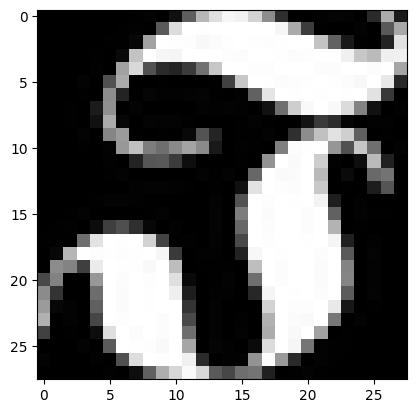

In [ ]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()

* 틀린 이미지만 확인해보기

In [ ]:
len(test_y)

3745

In [ ]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

203

idx = 2726
해당 인덱스의 이미지는 D
모델의 예측 : A
모델의 클래스별 확률 : 
-------------------
A 76.0
B 6.0
C 0.0
D 11.0
E 0.0
F 0.0
G 0.0
H 1.0
I 1.0
J 0.0
땡


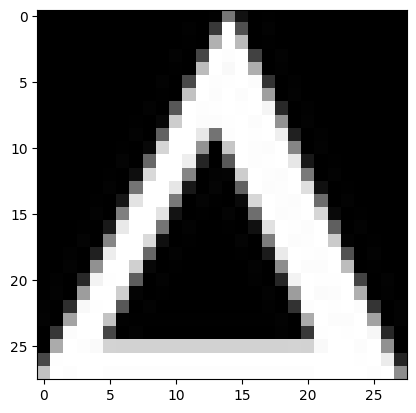

In [ ]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()